# TP3 

## Introducción

El objetivo del ejercicio es entrenar un modelo de segmentación basado en la arquitectura U-Net para resolver el problema de segmentación del neumotórax. 

El conjunto de datos está disponible en *Chest X-Ray Images with Peumothorax Masks* en Kaggle. Contiene 12 047 imágenes de radiografía de tórax y 12 047 máscaras de neumotórax, en dimensión 1024x1024 y formato png . Un neumotórax es un pulmón colapsado, que se produce cuando el aire se filtra en el espacio entre el pulmón y la pared torácica.

Los pasos para resolver el ejercicio son: procesar los datos, desarrollar la arquitectura del modelo, probar los parámetros y obtener el mejor resultado. 

La arquitectura U-Net está diseñada para la segmentación, en la que los objetos de las imágenes deben ser clasificados y ubicados correctamente. El modelo se comporta como una función de la forma *pred = f(image)*, donde la predicción es un mapa de la imagen en el que cada píxel ha sido correctamente clasificado. El modelo aprende a identificar objetos entrenando sobre máscaras, donde cada píxel de la imagen ha sido clasificado. La arquitectura U-Net consta de una parte de codificación y otra de decodificación y también utiliza conexiones de salto para aumentar el rendimiento.


## Procesamiento de datos 

Data will be downloaded through Kaggle API. 

In [ ]:
import pandas as pd

from PIL import Image
from IPython.display import clear_output 
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from pathlib import Path
import glob


In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
import json
api_token = {"username":"andrtorvestad","key":"47282d1bc85069a6c322ca5494676cc9"}
with open('/root/.kaggle/kaggle.json','w') as file:
  json.dump(api_token, file)
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%time
# download using api
!kaggle datasets download -d vbookshelf/pneumothorax-chest-xray-images-and-masks
# unzip the downloaded file
!unzip pneumothorax-chest-xray-images-and-masks.zip

clear_output()

CPU times: user 2.92 s, sys: 450 ms, total: 3.37 s
Wall time: 2min 4s


The data is now downloaded and available. 

In [ ]:
test_csv = pd.read_csv('/content/siim-acr-pneumothorax/stage_1_test_images.csv')
train_csv = pd.read_csv('/content/siim-acr-pneumothorax/stage_1_train_images.csv')

Se crea una función que selecciona imágenes sólo de pacientes con patología y las divide en datasets.

In [ ]:
import tensorflow as tf

transform = A.Compose([
    A.RandomRotate90(),
    A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
    A.Blur(blur_limit=3),
])

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, path, choose_set, img_prefix, mask_prefix, section="/*", transform=False, batch_size=4, dim=(256,256), n_channels=1, shuffle=True):
        'Initialization'
        self.path = path
        self.choose_set = choose_set
        self.section = section
        self.transform = transform
        self.n_channels = n_channels
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.filenames = [file.name for file in Path(path).glob(image_prefix+section+choose_set+"_1_.png")]
        self.on_epoch_end()
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(filenames)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        np.random.shuffle(self.filenames)

    def __data_generation(self, filenames):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, filename in enumerate(filenames):
#          while (i < self.set_size):
            img = Image.open(self.path + self.img_prefix + filename).resize(self.dim)
            mask = Image.open(self.path + self.mask_prefix + filename).resize(self.dim)
            img = np.array(img).reshape(*self.dim, self.n_channels)/255
            mask = np.array(mask).reshape(*self.dim, self.n_channels)/255
            if self.transform:
                trf = self.transform(image = img, mask = mask)
                X[i,...] = trf['image']
                y[i,...] = trf['mask']
            else:
                X[i,...] = img
                y[i,...] = mask
        return X,y

In [ ]:
path = '/content/siim-acr-pneumothorax/'
image_prefix = 'png_images/'
mask_prefix = 'png_masks/'

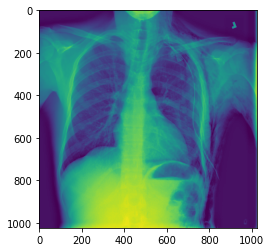

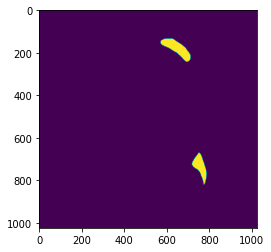

In [ ]:
# Example of an image
img_ex = Image.open("/content/siim-acr-pneumothorax/png_images/1000_train_1_.png")
mask_ex = Image.open('/content/siim-acr-pneumothorax/png_masks/1000_train_1_.png')

plt.imshow(img_ex)
plt.show()
plt.imshow(mask_ex)
plt.show()

El dataset está organizado

In [ ]:
%%time

BATCH_SIZE = 4

datagen_train = DataGenerator(
    path,
    "train",
    image_prefix,
    mask_prefix,
    section = "/88*",
    transform = transform,
    batch_size = BATCH_SIZE  
)

datagen_val = DataGenerator(
    path,
    "test",
    image_prefix,
    mask_prefix,
    transform = False,
    batch_size = BATCH_SIZE   
)

CPU times: user 26.2 ms, sys: 13.9 ms, total: 40.1 ms
Wall time: 41.2 ms


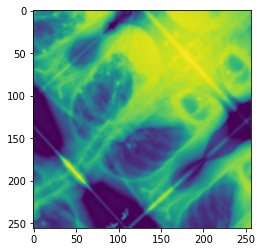

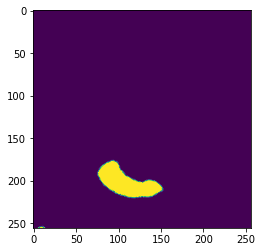

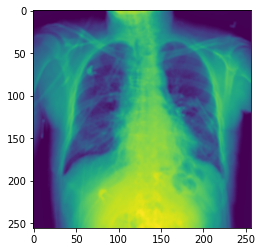

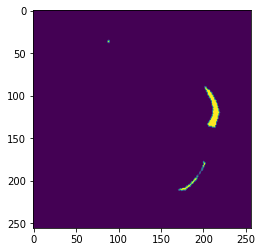

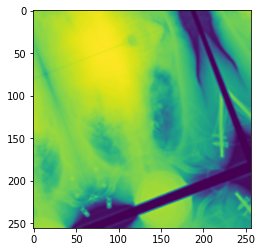

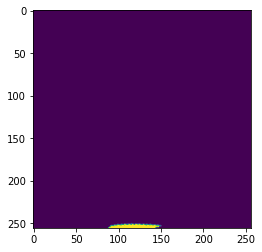

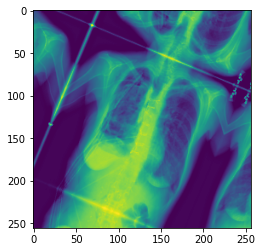

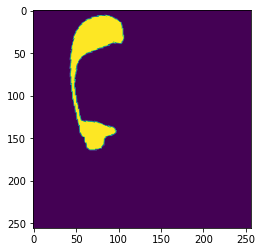

In [ ]:
for idx in range(BATCH_SIZE):
    plt.imshow(datagen_train[0][0][idx].reshape(256,256))
    plt.show()
    plt.imshow(datagen_train[0][1][idx].reshape(256,256))
    plt.show()

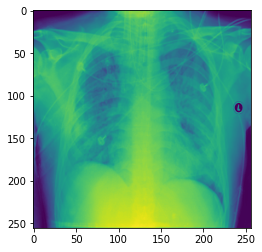

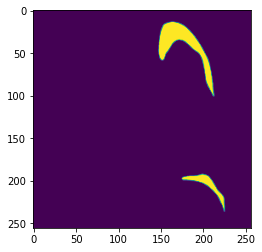

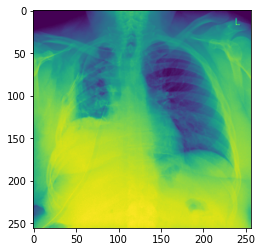

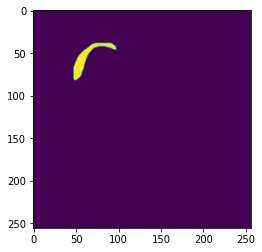

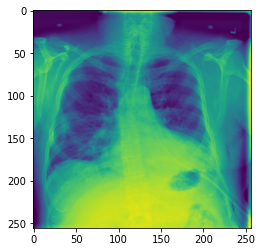

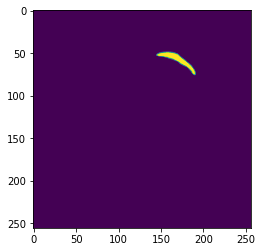

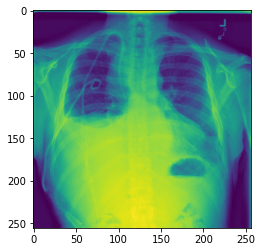

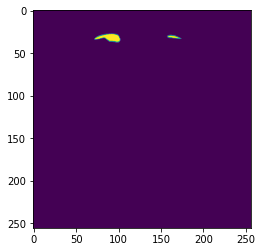

In [ ]:
for idx in range(BATCH_SIZE):
    plt.imshow(datagen_val[0][0][idx].reshape(256,256))
    plt.show()
    plt.imshow(datagen_val[0][1][idx].reshape(256,256))
    plt.show()

## Desarrollo de la arquitectura del modelo


In [ ]:
# Import libraries
from PIL import Image
import numpy as np
import albumentations as A

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from keras.utils.vis_utils import plot_model

Creación de la arquitectura U-net.

In [ ]:
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

Parámetros de eficacia del algoritmo (DICE, loss)

In [ ]:
def dice_coef(y_true, y_pred, smooth=0):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

### Primer modelo

In [ ]:
model = UNet((256,256,1), start_ch=32, depth=2, batchnorm=False, residual = True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

El diagrama explica el funcionamiento de la arquitectura U-net y la codificación y decodificación respectivas.

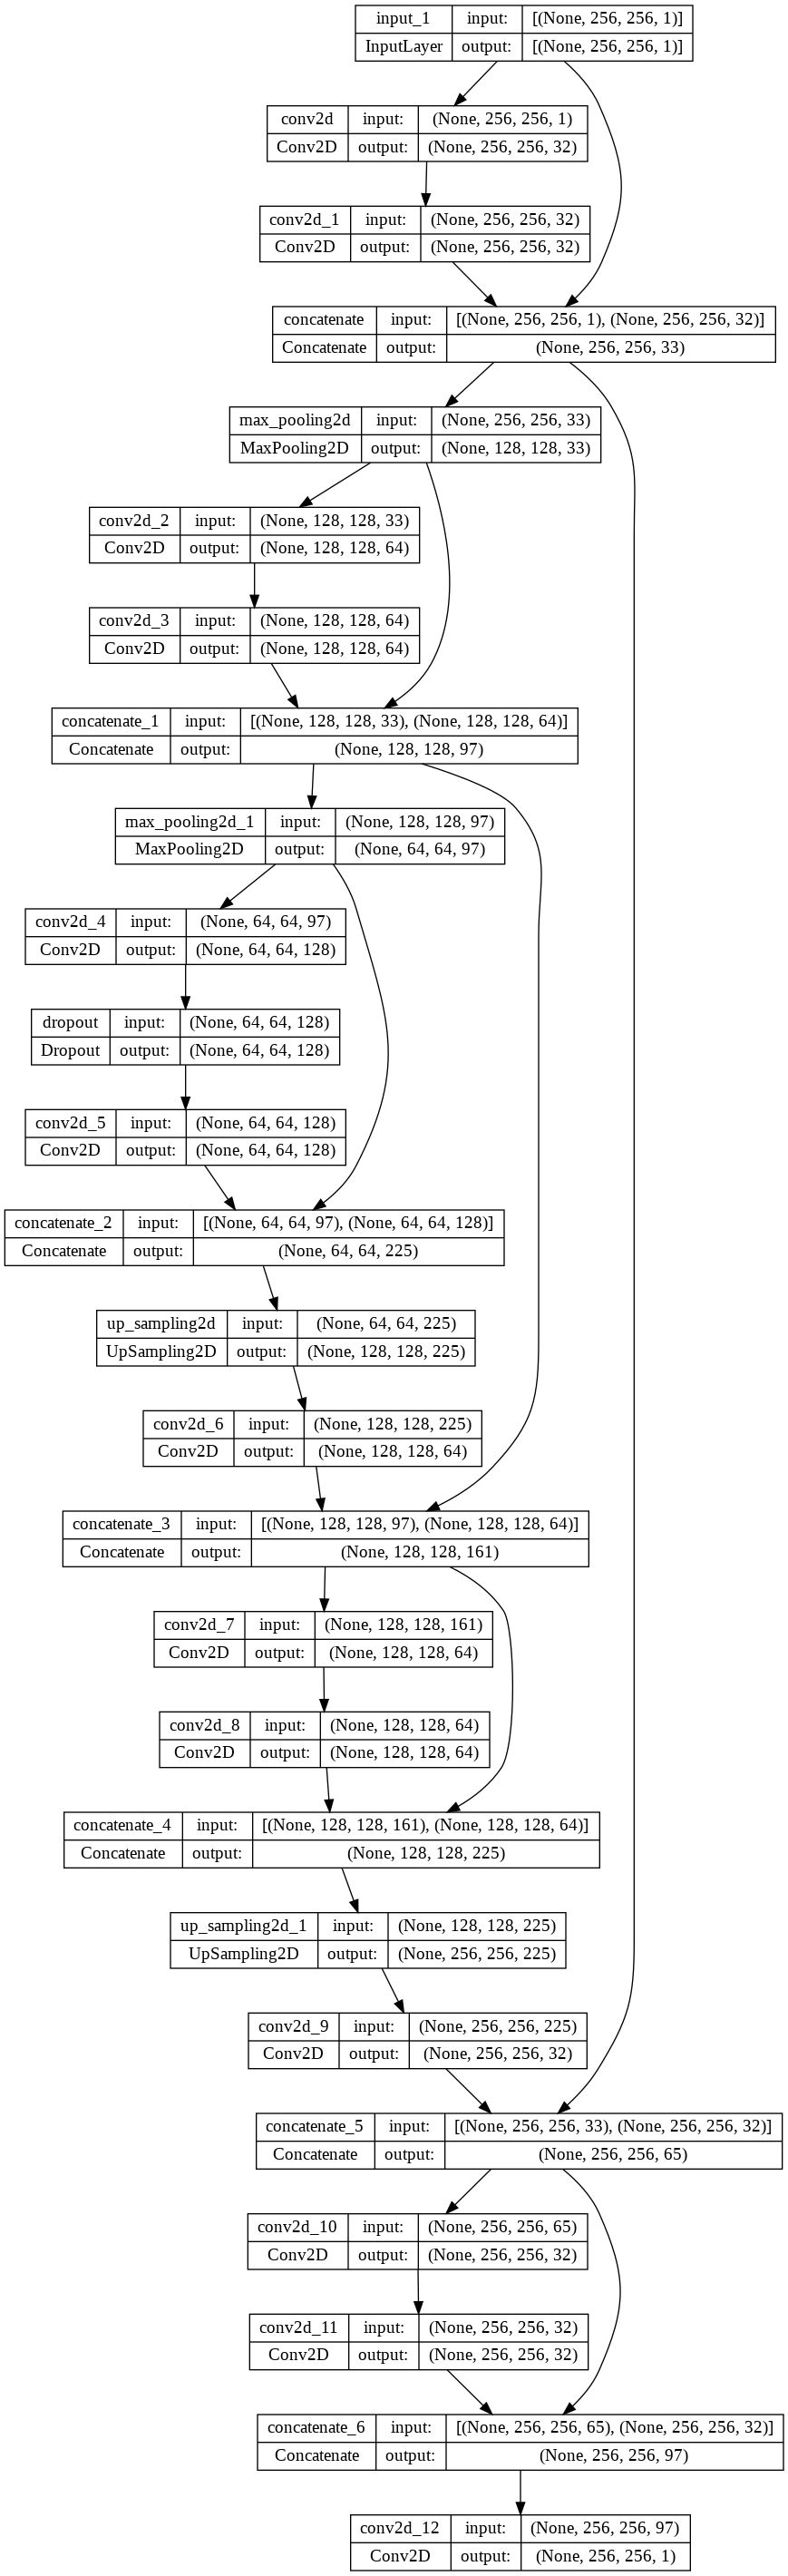

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss=dice_coef_loss, optimizer=Adam(1e-3), metrics = dice_coef)

In [ ]:
%%time
hist = model.fit(datagen_train, epochs = 11, validation_data=datagen_train)

Epoch 1/11
2/2 [==============================] - 27s 15s/step - loss: 0.9703 - dice_coef: 0.0297 - val_loss: 0.9727 - val_dice_coef: 0.0273
Epoch 2/11
2/2 [==============================] - 22s 14s/step - loss: 0.9638 - dice_coef: 0.0362 - val_loss: 0.9714 - val_dice_coef: 0.0286
Epoch 3/11
2/2 [==============================] - 24s 14s/step - loss: 0.9796 - dice_coef: 0.0204 - val_loss: 0.9675 - val_dice_coef: 0.0325
Epoch 4/11
2/2 [==============================] - 20s 12s/step - loss: 0.9726 - dice_coef: 0.0274 - val_loss: 0.9704 - val_dice_coef: 0.0296
Epoch 5/11
2/2 [==============================] - 22s 14s/step - loss: 0.9705 - dice_coef: 0.0295 - val_loss: 0.9608 - val_dice_coef: 0.0392
Epoch 6/11
2/2 [==============================] - 21s 12s/step - loss: 0.9674 - dice_coef: 0.0326 - val_loss: 0.9745 - val_dice_coef: 0.0255
Epoch 7/11
2/2 [==============================] - 21s 12s/step - loss: 0.9606 - dice_coef: 0.0394 - val_loss: 0.9719 - val_dice_coef: 0.0281
Epoch 8/11
2/

In [ ]:
def plotHistory(hist, title):
  plt.plot(hist.history['val_loss'], label='val_loss')
  plt.plot(hist.history['loss'], label='loss')
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.legend()
  plt.title(title)
  plt.show

def plotDice(hist, title):
  plt.plot(hist.history['val_dice_coef'], label='val_dice_coef')
  plt.plot(hist.history['dice_coef'], label='dice_coef')
  plt.ylabel("Dice Coefficient")
  plt.xlabel("Epochs")
  plt.legend()
  plt.title(title)
  plt.show

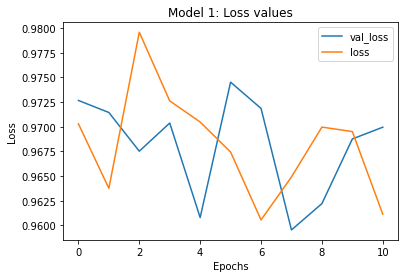

In [ ]:
plotHistory(hist, "Model 1: Loss values")

Como se puede ver en la figura anterior, el modelo no aprende y la curva dloss no tiene una tendencia descendente, señal de que el modelo no funciona como debería.

In [ ]:
preds = model.predict(datagen_val)

72/72 [==============================] - 151s 2s/step


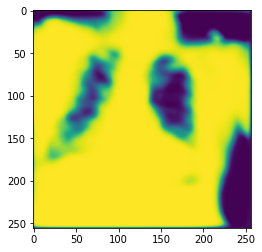

In [ ]:
plt.imshow(preds[7].reshape(256,256))

La imagen muestra una predicción: el algoritmo colorea las zonas en las que podría producirse la enfermedad y no colorea las que son seguras.

## Mejora del modelo a traves de parametros
Aumenta el tamaño del batch

Primero se genera un nuevo dataset con un tamaño de batch mayor. Sin embargo, no se puede aumentar demasiado el tamaño del batch, ya que esto ralentiza mucho el ajuste del modelo. Se intentó aumentar el número de muestras, pero el modelo necesitaba demasiado tiempo para funcionar. 
 

In [ ]:
%%time

BATCH_SIZE = 8

datagen_train2 = DataGenerator(
    path,
    "train",
    image_prefix,
    mask_prefix,
    section = "/88*",
    transform = transform,
    batch_size = BATCH_SIZE  
)

datagen_val2 = DataGenerator(
    path,
    "train",
    image_prefix,
    mask_prefix,
    section = "/111*",
    transform = False,
    batch_size = BATCH_SIZE
)

CPU times: user 42.2 ms, sys: 12.9 ms, total: 55.1 ms
Wall time: 81.8 ms


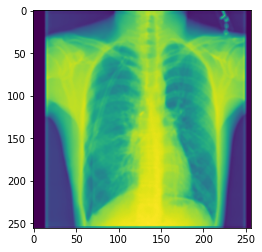

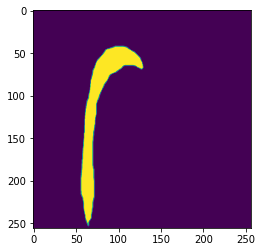

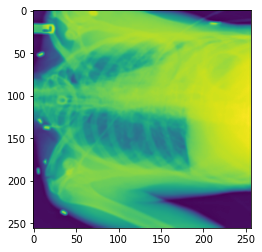

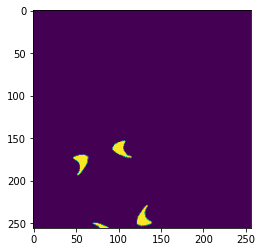

In [ ]:
for idx in range(2):
    plt.imshow(datagen_train2[0][0][idx].reshape(256,256))
    plt.show()
    plt.imshow(datagen_train2[0][1][idx].reshape(256,256))
    plt.show()

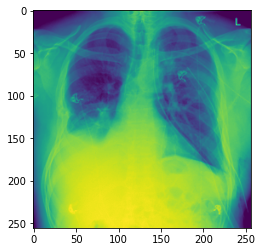

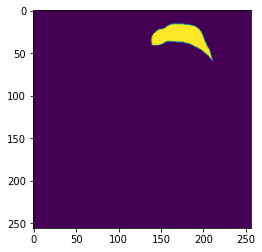

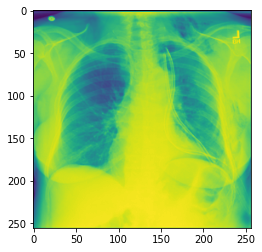

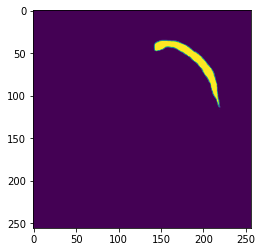

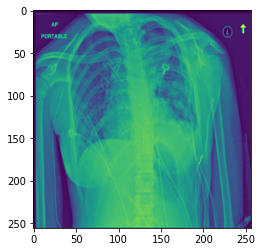

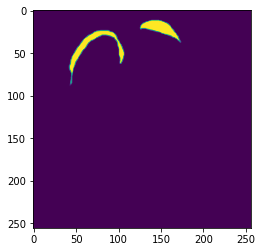

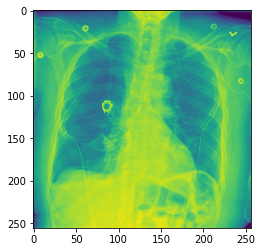

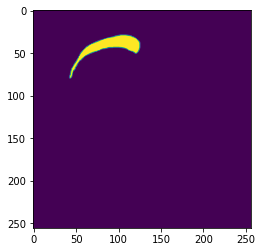

In [ ]:
for idx in range(4):
    plt.imshow(datagen_val2[0][0][idx].reshape(256,256))
    plt.show()
    plt.imshow(datagen_val2[0][1][idx].reshape(256,256))
    plt.show()

Se normaliza el lote, pero con el mismo tamaño

In [ ]:
model2 = UNet((256,256,1), depth=2, batchnorm=True)
model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_50 (Conv2D)             (None, 256, 256, 64  640         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 256, 256, 64  256        ['conv2d_50[0][0]']              
 ormalization)                  )                                                           

La normalización del batch aumenta considerablemente el número de parámetros posibles, lo que ralentiza el tiempo de ejecución del modelo. 

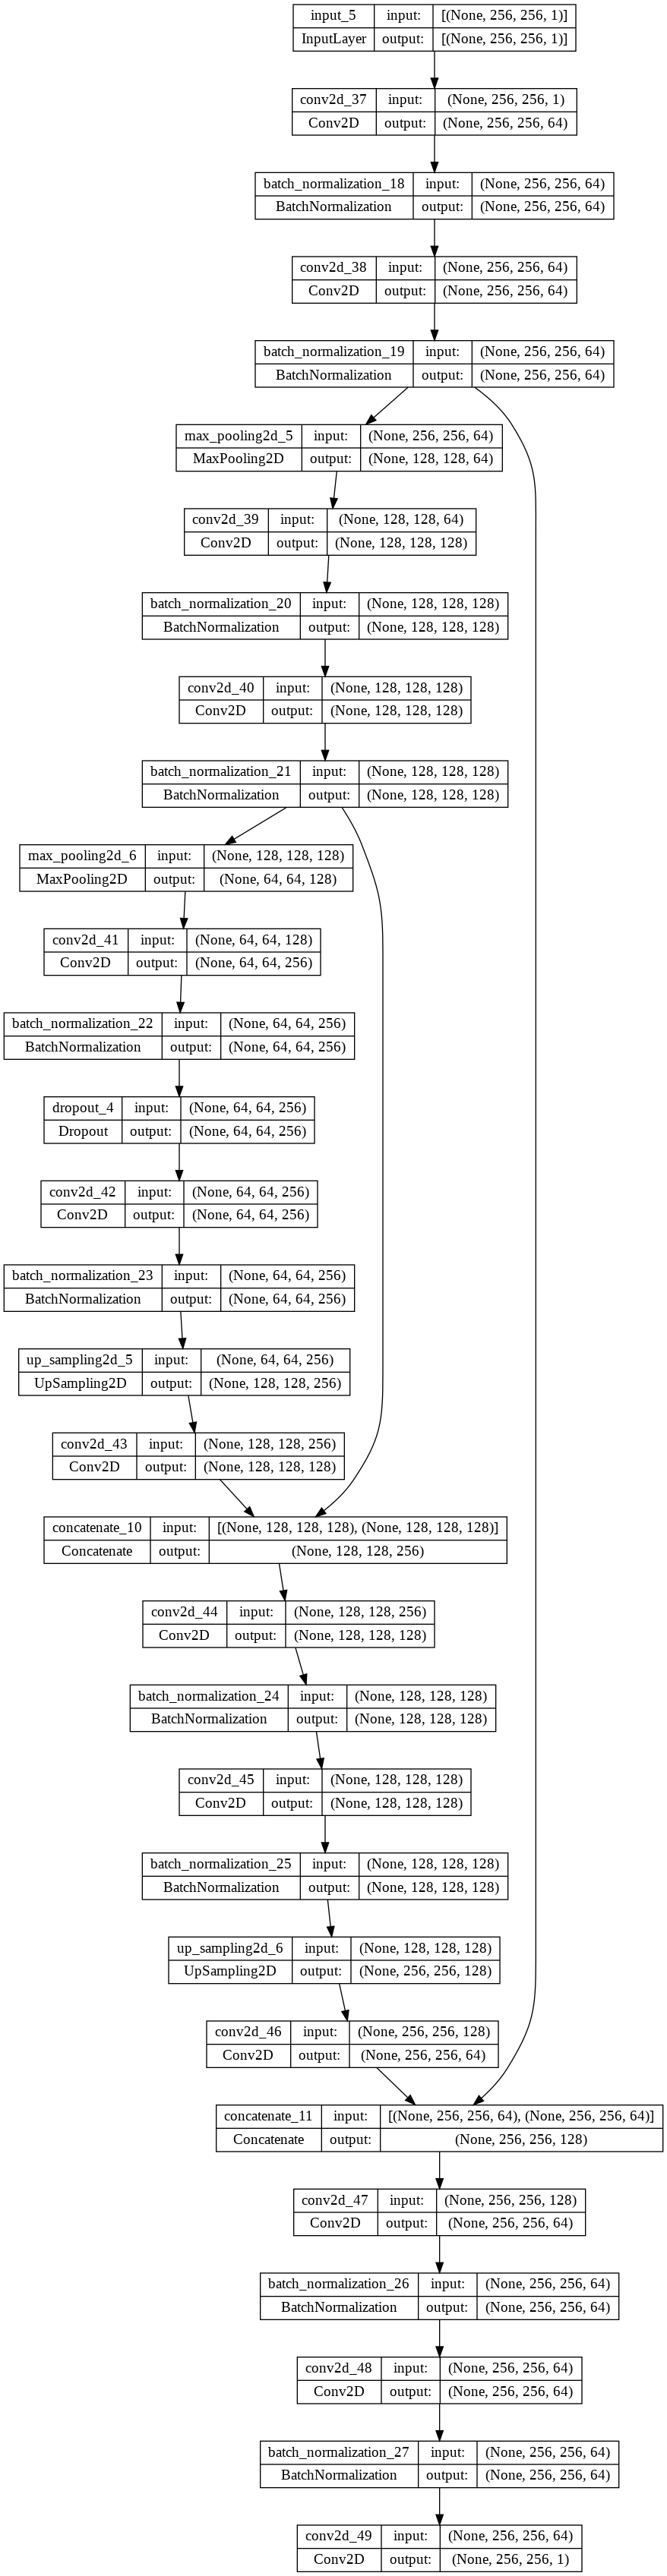

In [ ]:
plot_model(model2, show_shapes=True, show_layer_names=True)

In [ ]:
model2.compile(loss=dice_coef_loss, optimizer=Adam(1e-3), metrics = dice_coef)

In [ ]:
%%time
hist2 = model2.fit(datagen_train2, epochs = 11, validation_data=datagen_val2)

Epoch 1/11
1/1 [==============================] - 54s 54s/step - loss: 0.9779 - dice_coef: 0.0221 - val_loss: 0.9756 - val_dice_coef: 0.0244
Epoch 2/11
1/1 [==============================] - 49s 49s/step - loss: 0.9733 - dice_coef: 0.0267 - val_loss: 0.9756 - val_dice_coef: 0.0244
Epoch 3/11
1/1 [==============================] - 49s 49s/step - loss: 0.9502 - dice_coef: 0.0498 - val_loss: 0.9755 - val_dice_coef: 0.0245
Epoch 4/11
1/1 [==============================] - 48s 48s/step - loss: 0.9386 - dice_coef: 0.0614 - val_loss: 0.9755 - val_dice_coef: 0.0245
Epoch 5/11
1/1 [==============================] - 48s 48s/step - loss: 0.9541 - dice_coef: 0.0459 - val_loss: 0.9754 - val_dice_coef: 0.0246
Epoch 6/11
1/1 [==============================] - 49s 49s/step - loss: 0.9392 - dice_coef: 0.0608 - val_loss: 0.9752 - val_dice_coef: 0.0248
Epoch 7/11
1/1 [==============================] - 54s 54s/step - loss: 0.9325 - dice_coef: 0.0675 - val_loss: 0.9751 - val_dice_coef: 0.0249
Epoch 8/11
1/

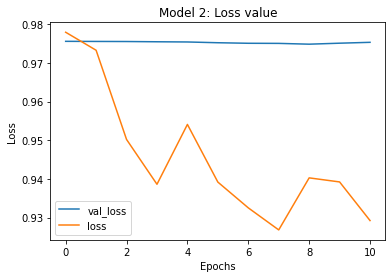

In [ ]:
plotHistory(hist2, "Model 2: Loss value")

Esta vez, el entrenamiento dura 13 minutos y, por tanto, no es muy útil para jugar con los parámetros. 

El modelo "mejorado" no da lugar a un modelo mejorado, a pesar de la normalización por lotes y el aumento del tiempo de entrenamiento, como se ve en el valor de la pérdida para el conjunto de validación. 

Como antes, parece que no es capaz de aprender ningún conocimiento general. Sin embargo, esta vez sí mejora en el conjunto de entrenamiento. Sin embargo, este valor sigue siendo bastante pequeño, ya que el coeficiente de los dados sigue siendo sólo de 0,07. 

En el conjunto de validación, el coeficiente de los dados es incluso menor que antes. Esto podría deberse a que el conjunto de validación de la última vez era el conjunto del tren, lo que hace que se compruebe en muestras ya conocidas y, por tanto, se obtengan mejores resultados de los que deberían. 

Resulta difícil seguir trabajando debido al largo tiempo de entrenamiento de los modelos y a la falta de resultados del modelo mejorado.

In [ ]:
preds2 = model2.predict(datagen_val2)

1/1 [==============================] - 12s 12s/step


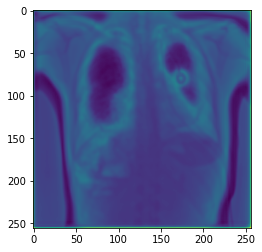

In [ ]:
plt.imshow(preds2[7].reshape(256,256))

La máscara predicha es esta vez diferente de las primeras predicciones, ya que parece tener valores más suavizados. Sin embargo, parece que sigue identificando el neumotórax de forma inversa, ya que el cuerpo se resalta y partes de los pulmones no. 

### Conclusión

Como se ve en los ejemplos anteriores, la red neuronal no rinde. 
El modelo requiere mucho tiempo de cálculo, lo que dificulta su ajuste. Los resultados también son pobres, lo que hace que un mayor ajuste parezca inútil. El mejor coeficiente de dados fue de 0,03, lo que significa que no hay solapamiento entre la predicción y el valor real. 

Una de las razones podría ser el dataset. Es demasiado grande para ejecutar más de 100 muestras de la misma en un entrenamiento (ya que esto provoca un accidente), pero ejecutar sólo 100 muestras no es suficiente para entrenar un modelo tan grande como el U-Net. 

Otra razón podría ser los problemas con la forma en que los modelos leen los objetos de clase del generador de datos, causando algún tipo de problema aquí. 

En conclusión, creo que para que funcione se necesita mucha más potencia de cálculo. El problema parece ser demasiado grande para ser manejado en jupyter notebook.